In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")   # add parent directory to Python path
import functions
from pathlib import Path
from tensorflow import keras
import csv

In [3]:
voltage = functions.load_voltage("../data/sample_8_8.csv")

In [4]:
voltage.shape

(192, 3334)

In [5]:
APD, DI, BCL = functions.get_APD_DI_BCL(voltage)

c:\Users\xan37\OneDrive - Georgia Institute of Technology\Documents\GitHub\defibrillation\jupyter_script\..\functions.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return (y0 * (x1-x) + y1 * (x-x0)) / (x1-x0)


Text(0.5, 0, 'Cycle Period (ms)')

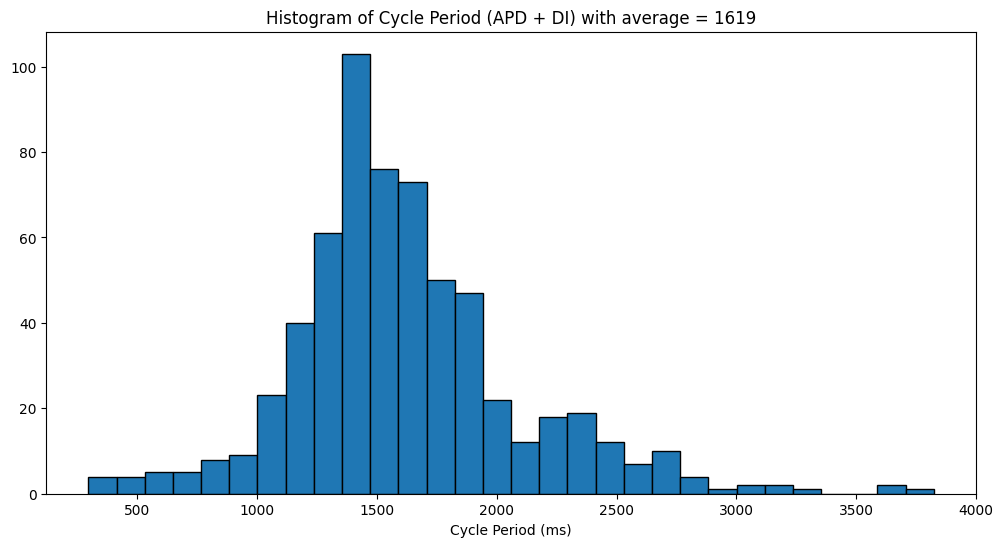

In [6]:
# plot the histogram of BCL
plt.figure(figsize=(12, 6))
plt.hist(BCL, bins=30, edgecolor='black')
plt.title(f'Histogram of Cycle Period (APD + DI) with average = {np.mean(BCL):.0f}')
plt.xlabel('Cycle Period (ms)')


Text(0.5, 1.0, 'initial condition for 1000ms simulation')

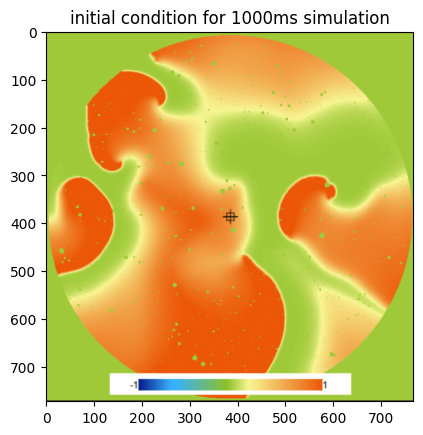

In [7]:
# show picture in file "../Re_ defibrillation codes/fcolor.png"
plt.imshow(plt.imread("../Re_ defibrillation codes/fcolor.png"))
plt.title('initial condition for 1000ms simulation')


In [8]:
loc = []
with open("../Re_ defibrillation codes/maskcirclenew1.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        i = -1
        for value in row[2:]:
            i += 1
            if i % 4 ==0:
                loc.append(int(value))
circle_area = sum(loc)/len(loc)

In [9]:
FTE = []
with open("../data/FTE_fcolor.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        for value in row[1:]:
            FTE.append(float(value)/circle_area)

Text(0, 0.5, 'FTE')

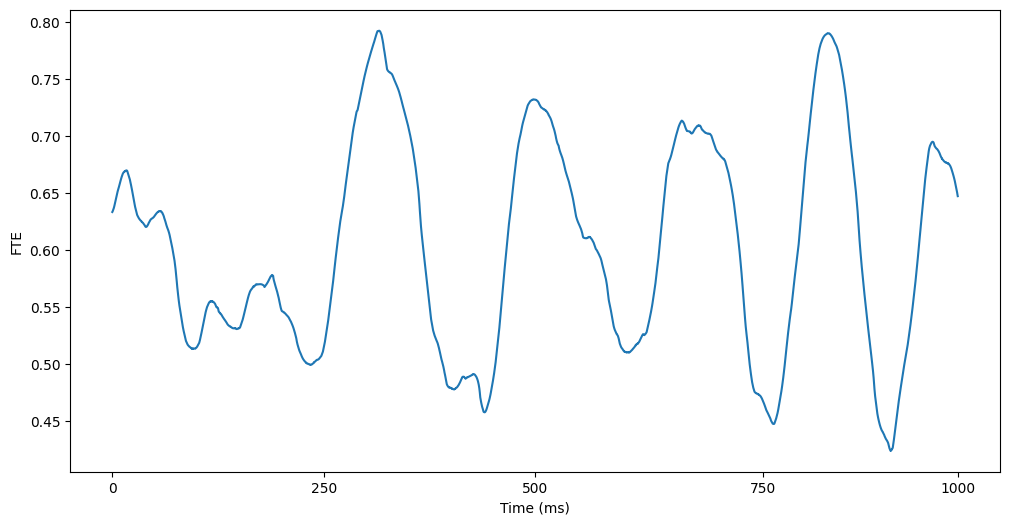

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(FTE)
# make x axis tick from [0,33333] to [0,1000]
plt.xticks(ticks=[0, 33333//4,33333//2,33333//1.3, 33333], labels=[0, 250,500, 750,1000])
plt.xlabel('Time (ms)')
plt.ylabel('FTE')